# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

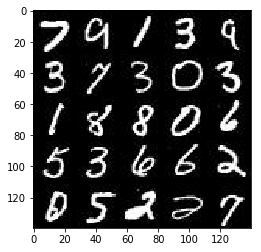

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

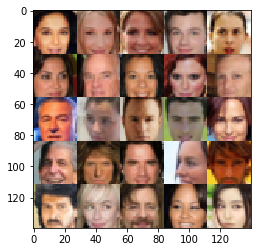

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.01
    with tf.variable_scope('discriminator', reuse=reuse) as discriminator:

        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        x3 = tf.layers.conv2d(relu2, 32, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*32))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    alpha = 0.01
    reuse = True if not is_train else False
    with tf.variable_scope('generator', reuse=reuse) as generator:
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
#         x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=1, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=is_train)
#         x3 = tf.maximum(alpha * x3, x3)

        x4 = tf.image.resize_nearest_neighbor(x2, (7,7))
        x4 = tf.layers.conv2d_transpose(x4, 128, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
#         x5 = tf.layers.conv2d_transpose(x4, 8, 5, strides=1, padding='same')
#         x5 = tf.layers.batch_normalization(x5, training=is_train)
#         x5 = tf.maximum(alpha * x5, x5)

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
#     smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_depth = 1 if data_image_mode == 'L' else 3
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_depth)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_images = show_n_images
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = 2 * batch_images
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_depth, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6853... Generator Loss: 0.3047
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 0.7011... Generator Loss: 0.9100
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 0.7105... Generator Loss: 1.1931
Epoch 1/2... Discriminator Loss: 0.5461... Generator Loss: 1.6237
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 0.9155
Epoch 1/2... Discriminator Loss: 0.5506... Generator Loss: 1.3530
Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 1.6508


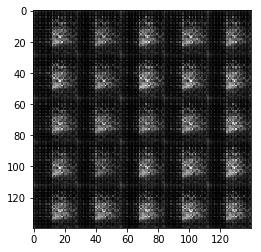

Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 1.7993
Epoch 1/2... Discriminator Loss: 0.2653... Generator Loss: 2.3038
Epoch 1/2... Discriminator Loss: 0.3814... Generator Loss: 1.9685
Epoch 1/2... Discriminator Loss: 0.3702... Generator Loss: 1.8804
Epoch 1/2... Discriminator Loss: 0.1572... Generator Loss: 2.5885
Epoch 1/2... Discriminator Loss: 0.2409... Generator Loss: 2.1819
Epoch 1/2... Discriminator Loss: 0.2024... Generator Loss: 2.8125
Epoch 1/2... Discriminator Loss: 0.1525... Generator Loss: 2.3651
Epoch 1/2... Discriminator Loss: 0.1437... Generator Loss: 2.6772
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 1.5711


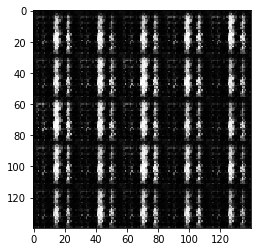

Epoch 1/2... Discriminator Loss: 0.3450... Generator Loss: 1.7964
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.4486
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 0.3926... Generator Loss: 2.9067
Epoch 1/2... Discriminator Loss: 0.1708... Generator Loss: 2.7326
Epoch 1/2... Discriminator Loss: 0.1108... Generator Loss: 2.9282
Epoch 1/2... Discriminator Loss: 0.4572... Generator Loss: 1.6752
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 1.7396
Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 1.8304
Epoch 1/2... Discriminator Loss: 0.3089... Generator Loss: 2.2376


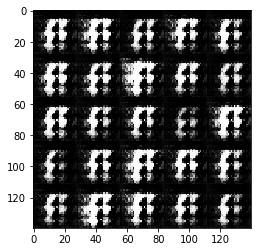

Epoch 1/2... Discriminator Loss: 0.2709... Generator Loss: 1.9948
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 1.8976
Epoch 1/2... Discriminator Loss: 0.2285... Generator Loss: 2.2257
Epoch 1/2... Discriminator Loss: 0.1466... Generator Loss: 2.9259
Epoch 1/2... Discriminator Loss: 0.2317... Generator Loss: 2.6905
Epoch 1/2... Discriminator Loss: 0.1418... Generator Loss: 2.9363
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 4.3952
Epoch 1/2... Discriminator Loss: 0.6018... Generator Loss: 2.0608
Epoch 1/2... Discriminator Loss: 0.1985... Generator Loss: 2.1827
Epoch 1/2... Discriminator Loss: 0.2824... Generator Loss: 1.9682


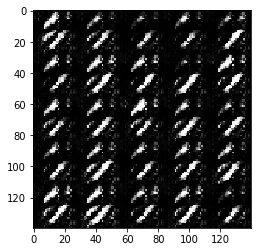

Epoch 1/2... Discriminator Loss: 0.4685... Generator Loss: 1.6062
Epoch 1/2... Discriminator Loss: 0.5341... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 0.4528... Generator Loss: 2.0463
Epoch 1/2... Discriminator Loss: 0.2181... Generator Loss: 4.2195
Epoch 1/2... Discriminator Loss: 0.2078... Generator Loss: 2.7616
Epoch 1/2... Discriminator Loss: 0.3233... Generator Loss: 2.0507
Epoch 1/2... Discriminator Loss: 0.1129... Generator Loss: 3.2480
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 0.1545... Generator Loss: 2.5488
Epoch 1/2... Discriminator Loss: 0.3392... Generator Loss: 2.2356


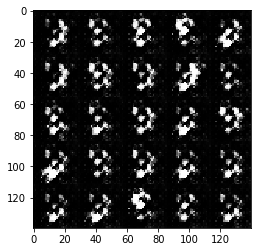

Epoch 1/2... Discriminator Loss: 0.2196... Generator Loss: 2.8402
Epoch 1/2... Discriminator Loss: 1.0356... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 0.2379... Generator Loss: 2.6326
Epoch 1/2... Discriminator Loss: 0.2839... Generator Loss: 2.6138
Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.8188
Epoch 1/2... Discriminator Loss: 0.2693... Generator Loss: 2.1284
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.4172
Epoch 1/2... Discriminator Loss: 0.4818... Generator Loss: 1.3655
Epoch 1/2... Discriminator Loss: 0.1799... Generator Loss: 2.5636
Epoch 1/2... Discriminator Loss: 0.1741... Generator Loss: 2.3972


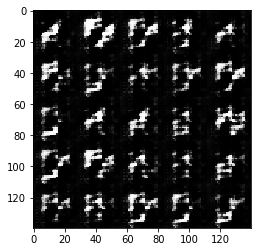

Epoch 1/2... Discriminator Loss: 0.5277... Generator Loss: 1.6230
Epoch 1/2... Discriminator Loss: 0.4180... Generator Loss: 2.0232
Epoch 1/2... Discriminator Loss: 0.2204... Generator Loss: 2.6220
Epoch 1/2... Discriminator Loss: 0.3375... Generator Loss: 2.0797
Epoch 1/2... Discriminator Loss: 0.2659... Generator Loss: 2.0856
Epoch 1/2... Discriminator Loss: 0.2115... Generator Loss: 2.6624
Epoch 1/2... Discriminator Loss: 0.3129... Generator Loss: 1.7956
Epoch 1/2... Discriminator Loss: 0.3728... Generator Loss: 2.1504
Epoch 1/2... Discriminator Loss: 0.2758... Generator Loss: 2.3592
Epoch 1/2... Discriminator Loss: 0.2481... Generator Loss: 2.1484


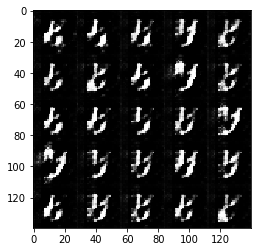

Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 2.9508
Epoch 1/2... Discriminator Loss: 0.2782... Generator Loss: 2.0754
Epoch 1/2... Discriminator Loss: 0.1257... Generator Loss: 3.0554
Epoch 1/2... Discriminator Loss: 0.7953... Generator Loss: 0.8142
Epoch 1/2... Discriminator Loss: 0.6286... Generator Loss: 1.1167
Epoch 1/2... Discriminator Loss: 0.2433... Generator Loss: 2.6164
Epoch 1/2... Discriminator Loss: 0.3490... Generator Loss: 2.2588
Epoch 1/2... Discriminator Loss: 0.4210... Generator Loss: 1.6174
Epoch 1/2... Discriminator Loss: 0.3214... Generator Loss: 2.2435
Epoch 1/2... Discriminator Loss: 0.4506... Generator Loss: 3.2578


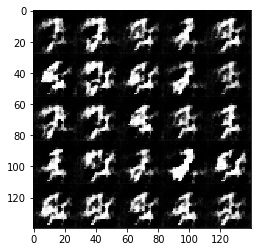

Epoch 1/2... Discriminator Loss: 0.5640... Generator Loss: 1.1939
Epoch 1/2... Discriminator Loss: 0.2230... Generator Loss: 2.5991
Epoch 1/2... Discriminator Loss: 0.3654... Generator Loss: 1.6060
Epoch 1/2... Discriminator Loss: 0.3271... Generator Loss: 2.0951
Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 5.8936
Epoch 1/2... Discriminator Loss: 0.2463... Generator Loss: 4.1698
Epoch 1/2... Discriminator Loss: 0.3106... Generator Loss: 1.9615
Epoch 1/2... Discriminator Loss: 0.1563... Generator Loss: 2.5066
Epoch 1/2... Discriminator Loss: 0.1462... Generator Loss: 2.5976
Epoch 1/2... Discriminator Loss: 0.1861... Generator Loss: 4.2840


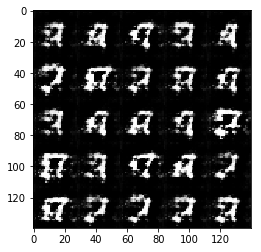

Epoch 1/2... Discriminator Loss: 0.4137... Generator Loss: 3.3701
Epoch 1/2... Discriminator Loss: 0.3242... Generator Loss: 1.8102
Epoch 1/2... Discriminator Loss: 0.4132... Generator Loss: 1.5673
Epoch 1/2... Discriminator Loss: 0.2331... Generator Loss: 2.8077
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 2.2581
Epoch 1/2... Discriminator Loss: 0.5901... Generator Loss: 3.2263
Epoch 1/2... Discriminator Loss: 0.2522... Generator Loss: 2.0675
Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 2.1095
Epoch 1/2... Discriminator Loss: 0.2857... Generator Loss: 2.5802
Epoch 1/2... Discriminator Loss: 0.4084... Generator Loss: 2.2631


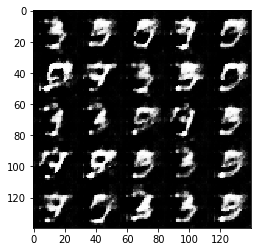

Epoch 1/2... Discriminator Loss: 0.2893... Generator Loss: 2.6001
Epoch 1/2... Discriminator Loss: 0.4473... Generator Loss: 1.7066
Epoch 1/2... Discriminator Loss: 0.4915... Generator Loss: 2.4641
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 1.7160
Epoch 1/2... Discriminator Loss: 0.3275... Generator Loss: 2.2385
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 2.3214
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 3.0002
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 2.9511
Epoch 1/2... Discriminator Loss: 0.4997... Generator Loss: 1.2735
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 0.6854


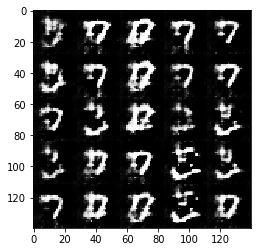

Epoch 1/2... Discriminator Loss: 0.4656... Generator Loss: 2.3642
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 3.0746
Epoch 1/2... Discriminator Loss: 0.4199... Generator Loss: 1.8315
Epoch 1/2... Discriminator Loss: 0.2202... Generator Loss: 2.5108
Epoch 1/2... Discriminator Loss: 0.2442... Generator Loss: 3.0148
Epoch 1/2... Discriminator Loss: 0.3923... Generator Loss: 1.5689
Epoch 1/2... Discriminator Loss: 0.4812... Generator Loss: 1.5669
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 2.6526
Epoch 1/2... Discriminator Loss: 0.5251... Generator Loss: 1.4294
Epoch 1/2... Discriminator Loss: 0.6128... Generator Loss: 1.9454


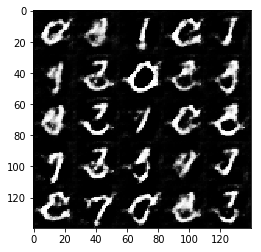

Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 2.1161
Epoch 1/2... Discriminator Loss: 0.4603... Generator Loss: 1.7111
Epoch 1/2... Discriminator Loss: 0.2960... Generator Loss: 1.9557
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 1.6154
Epoch 1/2... Discriminator Loss: 0.5831... Generator Loss: 1.5570
Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 2.7841
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 2.0948
Epoch 1/2... Discriminator Loss: 0.6985... Generator Loss: 0.9738
Epoch 1/2... Discriminator Loss: 0.6223... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 0.3658... Generator Loss: 1.7917


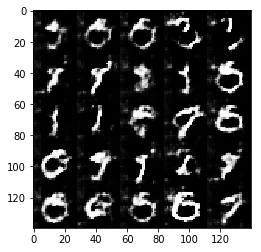

Epoch 1/2... Discriminator Loss: 0.8031... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 1.9389
Epoch 1/2... Discriminator Loss: 0.4033... Generator Loss: 1.7291
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.2445
Epoch 1/2... Discriminator Loss: 0.6426... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 0.4621... Generator Loss: 1.5128
Epoch 1/2... Discriminator Loss: 0.8090... Generator Loss: 0.8344
Epoch 1/2... Discriminator Loss: 0.6827... Generator Loss: 3.1264
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 0.8666
Epoch 1/2... Discriminator Loss: 0.5589... Generator Loss: 1.2516


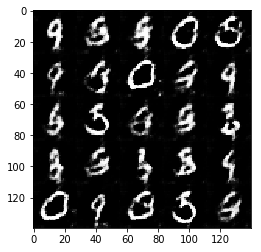

Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 2.0410
Epoch 1/2... Discriminator Loss: 0.3856... Generator Loss: 1.8818
Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 1.5736
Epoch 1/2... Discriminator Loss: 0.4317... Generator Loss: 2.0997
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 0.5561... Generator Loss: 2.7261
Epoch 1/2... Discriminator Loss: 0.5649... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 0.2708... Generator Loss: 2.3311
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 0.6717... Generator Loss: 1.1424


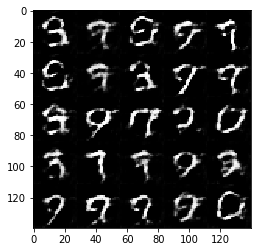

Epoch 1/2... Discriminator Loss: 0.3671... Generator Loss: 1.9023
Epoch 1/2... Discriminator Loss: 0.4071... Generator Loss: 1.8067
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 2.4273
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.0861
Epoch 1/2... Discriminator Loss: 0.3614... Generator Loss: 1.8098
Epoch 1/2... Discriminator Loss: 0.4046... Generator Loss: 1.7868
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.9258
Epoch 1/2... Discriminator Loss: 0.4037... Generator Loss: 3.4195
Epoch 1/2... Discriminator Loss: 0.6222... Generator Loss: 1.5873


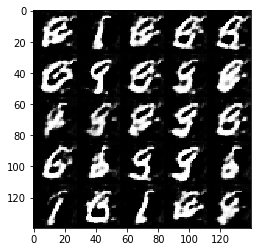

Epoch 1/2... Discriminator Loss: 0.3111... Generator Loss: 2.5335
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 2.1175
Epoch 1/2... Discriminator Loss: 0.3507... Generator Loss: 1.9903
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 0.4264... Generator Loss: 1.5252
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 1.5432
Epoch 1/2... Discriminator Loss: 0.5247... Generator Loss: 1.8672
Epoch 1/2... Discriminator Loss: 0.4600... Generator Loss: 1.5974
Epoch 1/2... Discriminator Loss: 0.4714... Generator Loss: 1.5932
Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 1.1074


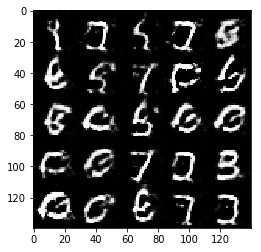

Epoch 1/2... Discriminator Loss: 0.4662... Generator Loss: 1.8207
Epoch 1/2... Discriminator Loss: 0.4567... Generator Loss: 1.6455
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 1.7517
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 1.4941
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.4332
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 2.6557
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 0.9265
Epoch 1/2... Discriminator Loss: 0.6689... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.0255... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 0.8140... Generator Loss: 2.4803


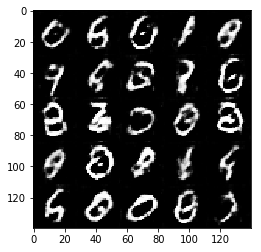

Epoch 1/2... Discriminator Loss: 0.8129... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 1.5546
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 2.0101
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 0.8662
Epoch 1/2... Discriminator Loss: 0.7858... Generator Loss: 2.8244
Epoch 1/2... Discriminator Loss: 0.6373... Generator Loss: 1.3293
Epoch 1/2... Discriminator Loss: 0.7783... Generator Loss: 0.9074
Epoch 2/2... Discriminator Loss: 0.4160... Generator Loss: 1.8944
Epoch 2/2... Discriminator Loss: 0.5920... Generator Loss: 1.0702
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 1.3510


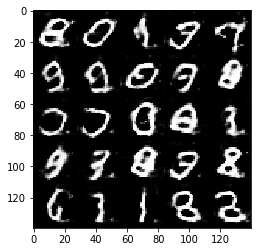

Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 1.7262
Epoch 2/2... Discriminator Loss: 0.7123... Generator Loss: 1.1206
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 1.1014
Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.6338
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 1.7506
Epoch 2/2... Discriminator Loss: 0.7540... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 0.5836
Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 1.6538
Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 0.6251... Generator Loss: 1.4785


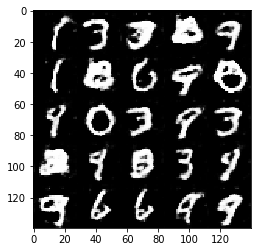

Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.6366
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.4648
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.5533
Epoch 2/2... Discriminator Loss: 0.5620... Generator Loss: 2.0854
Epoch 2/2... Discriminator Loss: 1.6248... Generator Loss: 0.3229
Epoch 2/2... Discriminator Loss: 0.8648... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 0.6487... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 0.7504... Generator Loss: 1.0240
Epoch 2/2... Discriminator Loss: 0.5949... Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 0.9348


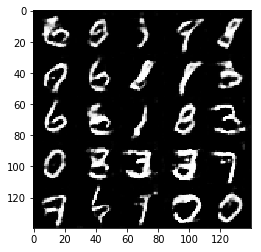

Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.1349
Epoch 2/2... Discriminator Loss: 0.7916... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 0.7590... Generator Loss: 1.2242
Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 0.7894
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 1.5268
Epoch 2/2... Discriminator Loss: 0.7290... Generator Loss: 1.1278
Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 2.4949
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.6119


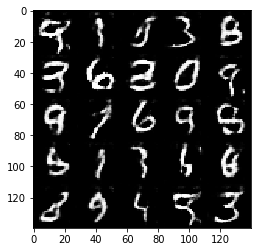

Epoch 2/2... Discriminator Loss: 0.7891... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 0.7126... Generator Loss: 1.2393
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 0.5719... Generator Loss: 1.3960
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.5867
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.5114
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 1.9977
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.1965
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 0.9185


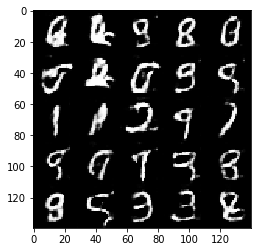

Epoch 2/2... Discriminator Loss: 0.5789... Generator Loss: 1.1453
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 0.9745
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 3.3091
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.5316
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.4562
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.0894


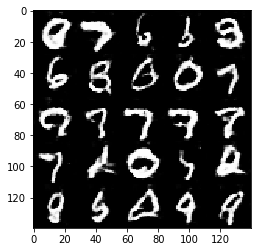

Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 1.6091... Generator Loss: 0.2798
Epoch 2/2... Discriminator Loss: 0.7507... Generator Loss: 0.8996
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.4197
Epoch 2/2... Discriminator Loss: 1.5971... Generator Loss: 0.3347
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.2623
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 0.9158
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.4368
Epoch 2/2... Discriminator Loss: 0.6773... Generator Loss: 1.1398


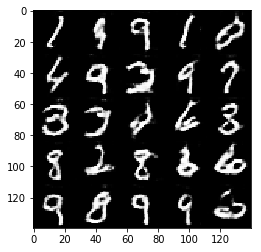

Epoch 2/2... Discriminator Loss: 0.8386... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 0.5067... Generator Loss: 1.8779
Epoch 2/2... Discriminator Loss: 1.3513... Generator Loss: 0.4695
Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.1026
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.3942
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 1.5156
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 1.6431
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 0.9619
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 2.0569
Epoch 2/2... Discriminator Loss: 0.7144... Generator Loss: 1.1697


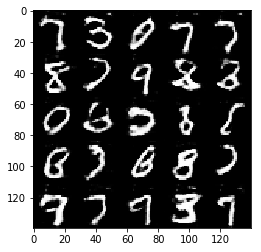

Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 2.3353
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.8586
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.7623
Epoch 2/2... Discriminator Loss: 0.5028... Generator Loss: 1.6651
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.1328
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.6344
Epoch 2/2... Discriminator Loss: 1.1495... Generator Loss: 0.5648
Epoch 2/2... Discriminator Loss: 0.6157... Generator Loss: 1.8942
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.2556
Epoch 2/2... Discriminator Loss: 0.7164... Generator Loss: 1.6632


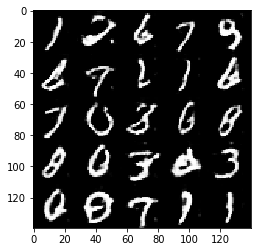

Epoch 2/2... Discriminator Loss: 0.6459... Generator Loss: 1.9254
Epoch 2/2... Discriminator Loss: 0.7053... Generator Loss: 1.0715
Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 0.5900... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.5206
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 2.3038
Epoch 2/2... Discriminator Loss: 0.6893... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 1.3077


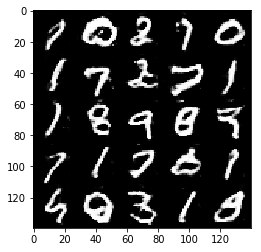

Epoch 2/2... Discriminator Loss: 0.6535... Generator Loss: 1.2979
Epoch 2/2... Discriminator Loss: 0.4738... Generator Loss: 2.0336
Epoch 2/2... Discriminator Loss: 0.8803... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 0.9291... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.2492
Epoch 2/2... Discriminator Loss: 0.6749... Generator Loss: 1.4443
Epoch 2/2... Discriminator Loss: 0.8089... Generator Loss: 1.2746
Epoch 2/2... Discriminator Loss: 0.6177... Generator Loss: 1.2654
Epoch 2/2... Discriminator Loss: 0.7327... Generator Loss: 3.2373
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 0.9872


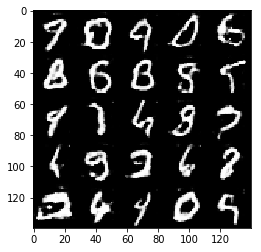

Epoch 2/2... Discriminator Loss: 0.6469... Generator Loss: 1.9514
Epoch 2/2... Discriminator Loss: 0.5370... Generator Loss: 2.1899
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 0.7275... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.2506
Epoch 2/2... Discriminator Loss: 0.5702... Generator Loss: 2.1617
Epoch 2/2... Discriminator Loss: 0.7827... Generator Loss: 2.0509
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.4021
Epoch 2/2... Discriminator Loss: 0.6410... Generator Loss: 1.0663


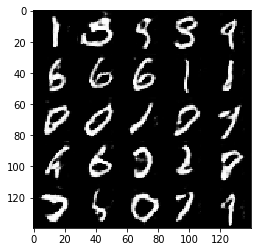

Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 0.7649
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 0.9113... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 0.9789
Epoch 2/2... Discriminator Loss: 0.9619... Generator Loss: 0.7313
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 0.9442
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.5280
Epoch 2/2... Discriminator Loss: 1.6089... Generator Loss: 3.1325
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 1.5290
Epoch 2/2... Discriminator Loss: 1.1864... Generator Loss: 2.2813


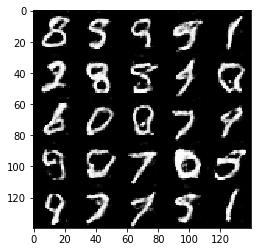

Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 0.4996... Generator Loss: 1.7256
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.5105
Epoch 2/2... Discriminator Loss: 0.5380... Generator Loss: 1.4415
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 1.6928


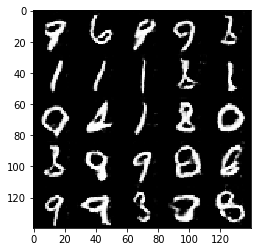

Epoch 2/2... Discriminator Loss: 1.8395... Generator Loss: 0.2469
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 1.0865
Epoch 2/2... Discriminator Loss: 0.6877... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 0.5598... Generator Loss: 1.6662
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 1.5999
Epoch 2/2... Discriminator Loss: 0.3972... Generator Loss: 1.8068
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.8260
Epoch 2/2... Discriminator Loss: 0.6236... Generator Loss: 1.0922


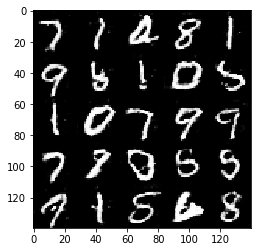

Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 0.3662... Generator Loss: 2.3393
Epoch 2/2... Discriminator Loss: 1.7450... Generator Loss: 0.2955
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 0.5504
Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.6211
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 1.0770
Epoch 2/2... Discriminator Loss: 0.6066... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 0.6732... Generator Loss: 1.1657
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.6918


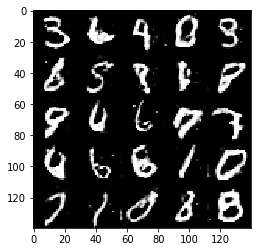

Epoch 2/2... Discriminator Loss: 0.6099... Generator Loss: 1.1521
Epoch 2/2... Discriminator Loss: 0.7470... Generator Loss: 1.8495
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 0.5220... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 1.2109... Generator Loss: 2.7629
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 0.9732
Epoch 2/2... Discriminator Loss: 0.7081... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.6300
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 1.0850... Generator Loss: 0.6633


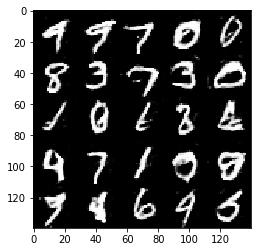

Epoch 2/2... Discriminator Loss: 0.6220... Generator Loss: 1.3022
Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 1.9045
Epoch 2/2... Discriminator Loss: 0.9584... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 0.4705... Generator Loss: 1.7282
Epoch 2/2... Discriminator Loss: 0.8332... Generator Loss: 0.7898
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 0.5463... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 0.9688... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 0.9351


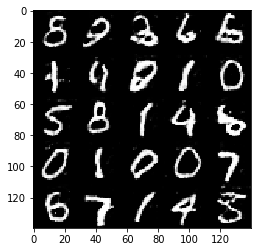

Epoch 2/2... Discriminator Loss: 0.4358... Generator Loss: 1.4946
Epoch 2/2... Discriminator Loss: 1.1700... Generator Loss: 0.5828
Epoch 2/2... Discriminator Loss: 0.7648... Generator Loss: 3.5416
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.6258
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.1867
Epoch 2/2... Discriminator Loss: 1.8801... Generator Loss: 0.3390
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.2436
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 1.7481
Epoch 2/2... Discriminator Loss: 0.8079... Generator Loss: 1.0075


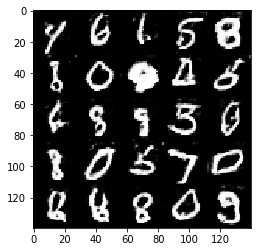

Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.7499
Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 2.0158
Epoch 2/2... Discriminator Loss: 0.3840... Generator Loss: 2.0399


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2594... Generator Loss: 0.0198
Epoch 1/1... Discriminator Loss: 3.5844... Generator Loss: 0.0427
Epoch 1/1... Discriminator Loss: 3.2332... Generator Loss: 0.0616
Epoch 1/1... Discriminator Loss: 3.4548... Generator Loss: 0.0596
Epoch 1/1... Discriminator Loss: 2.7664... Generator Loss: 0.1074
Epoch 1/1... Discriminator Loss: 2.5664... Generator Loss: 0.1521
Epoch 1/1... Discriminator Loss: 1.9206... Generator Loss: 0.3122
Epoch 1/1... Discriminator Loss: 2.2130... Generator Loss: 0.2920
Epoch 1/1... Discriminator Loss: 2.3278... Generator Loss: 0.3925
Epoch 1/1... Discriminator Loss: 1.9815... Generator Loss: 0.3660


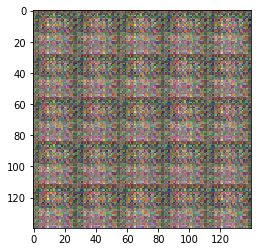

Epoch 1/1... Discriminator Loss: 1.7842... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.9881... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7477


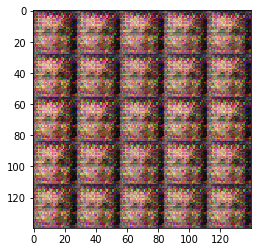

Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.0646... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 1.4668


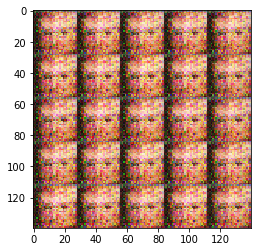

Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.2646
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 1.1579
Epoch 1/1... Discriminator Loss: 0.8843... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 1.7602
Epoch 1/1... Discriminator Loss: 0.3306... Generator Loss: 1.8977


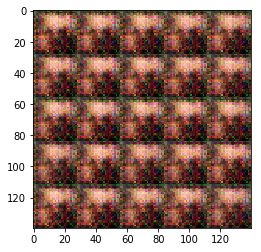

Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 1.4299
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 0.3157... Generator Loss: 2.1601


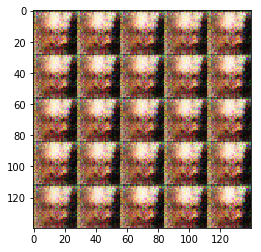

Epoch 1/1... Discriminator Loss: 0.3307... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 0.5008... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.5247
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 0.6347... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0901


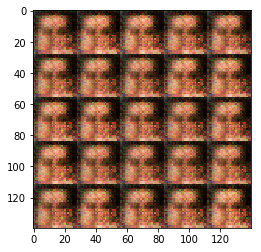

Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 0.3982... Generator Loss: 1.8129
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 1.5298
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 1.6374
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 1.7503
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.3693
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.2851


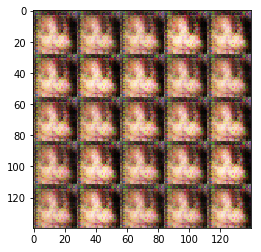

Epoch 1/1... Discriminator Loss: 0.5583... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 1.3612
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7615


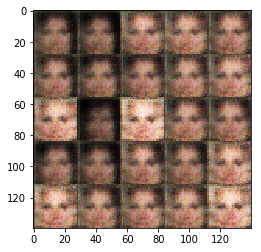

Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.0129


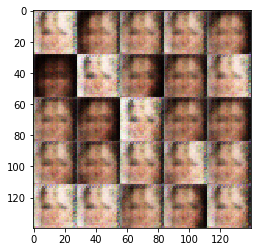

Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 1.8096


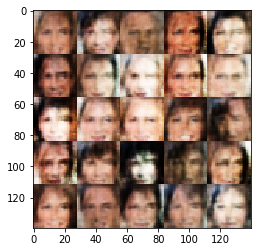

Epoch 1/1... Discriminator Loss: 0.3693... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 0.7540... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 2.0090
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 2.0283
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 2.1499
Epoch 1/1... Discriminator Loss: 0.1030... Generator Loss: 3.4856
Epoch 1/1... Discriminator Loss: 0.7187... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 2.3803
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 1.3825


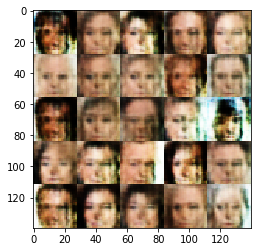

Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 1.1993
Epoch 1/1... Discriminator Loss: 0.3000... Generator Loss: 2.6660
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 2.6602
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 2.5443
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.7677
Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 1.9654
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 1.8592
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 1.3652
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.4910


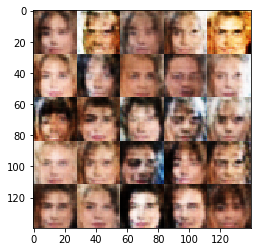

Epoch 1/1... Discriminator Loss: 0.3123... Generator Loss: 1.6545
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.9773
Epoch 1/1... Discriminator Loss: 0.3853... Generator Loss: 1.9008
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 1.9671
Epoch 1/1... Discriminator Loss: 0.2320... Generator Loss: 3.0926
Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 2.7648


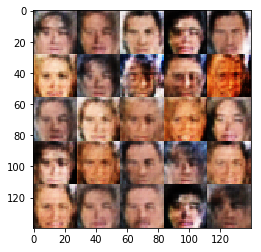

Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 4.0550
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 1.3441
Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.4660
Epoch 1/1... Discriminator Loss: 0.5038... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 0.4335... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 2.8963
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.7244
Epoch 1/1... Discriminator Loss: 0.5488... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.0570
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 1.9189


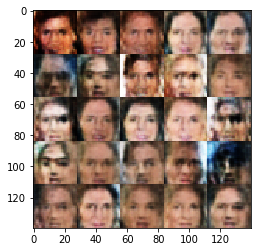

Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 5.2352
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 0.9144... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 1.7058
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.5584... Generator Loss: 1.3867
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 1.3800
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 0.7732


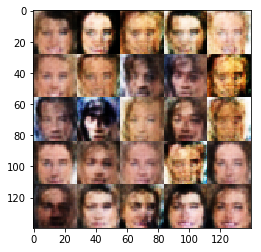

Epoch 1/1... Discriminator Loss: 0.6047... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 0.7759... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 0.3660... Generator Loss: 1.8640
Epoch 1/1... Discriminator Loss: 0.5160... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.4782
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 2.0432
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 3.7315
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 2.5607


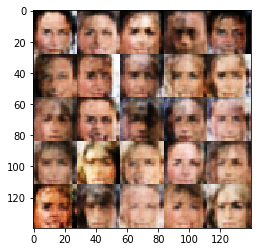

Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.2311
Epoch 1/1... Discriminator Loss: 0.5379... Generator Loss: 1.6946
Epoch 1/1... Discriminator Loss: 0.3995... Generator Loss: 2.2853
Epoch 1/1... Discriminator Loss: 0.3129... Generator Loss: 2.4245
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 1.9541
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 1.6757
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 2.1589
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 2.1419
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.4695


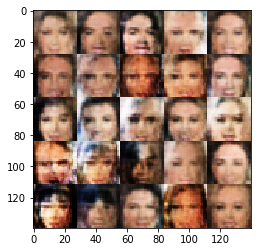

Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.5527
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 1.5914
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 3.2987
Epoch 1/1... Discriminator Loss: 0.4719... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 0.1497... Generator Loss: 3.3409
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.2604... Generator Loss: 2.6150


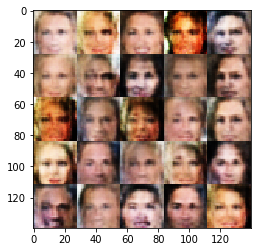

Epoch 1/1... Discriminator Loss: 0.4606... Generator Loss: 2.1417
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 0.2149... Generator Loss: 2.5763
Epoch 1/1... Discriminator Loss: 0.1788... Generator Loss: 2.8681
Epoch 1/1... Discriminator Loss: 0.2892... Generator Loss: 2.6376
Epoch 1/1... Discriminator Loss: 0.4859... Generator Loss: 2.0581
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 0.3425... Generator Loss: 1.7968


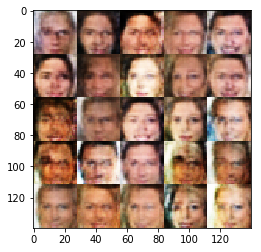

Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 3.3775
Epoch 1/1... Discriminator Loss: 0.2721... Generator Loss: 2.4588


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.